In [7]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np


class Grid: # Environment
  def __init__(self, width, height, start):
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # x means you can't go there
  # s means start position
  # number means reward at that state
  # .  .  .  1
  # .  x  . -1
  # s  .  .  .
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g



In [8]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt


SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

# NOTE: this is only policy evaluation, not optimization

def random_action(a, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

def play_game(grid, policy):
  # returns a list of states and corresponding rewards (not returns as in MC)
  # start at the designated start state
  s = (2, 0)
  grid.set_state(s)
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  return states_and_rewards


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {}
  states = grid.all_states()
  for s in states:
    V[s] = 0

  # repeat until convergence
  for it in range(1000):

    # generate an episode using pi
    states_and_rewards = play_game(grid, policy)
    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    for t in range(len(states_and_rewards) - 1):
      s, _ = states_and_rewards[t]
      s2, r = states_and_rewards[t+1]
      # we will update V(s) AS we experience the episode
      V[s] = V[s] + ALPHA*(r + GAMMA*V[s2] - V[s])

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)


rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.77| 0.86| 0.98| 0.00|
---------------------------
 0.67| 0.00|-0.94| 0.00|
---------------------------
 0.52|-0.36|-0.64|-0.92|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


Q Learning

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


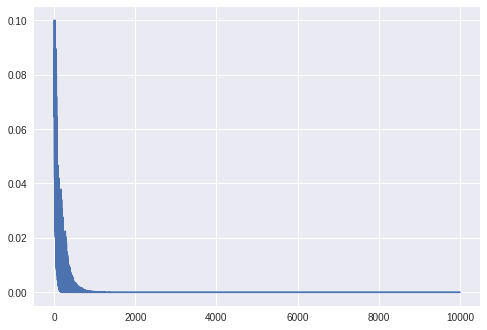

update counts:
---------------------------
 0.26| 0.05| 0.04| 0.00|
---------------------------
 0.12| 0.00| 0.01| 0.00|
---------------------------
 0.28| 0.07| 0.05| 0.11|
values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [6]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
#from grid_world import standard_grid, negative_grid
#from iterative_policy_evaluation import print_values, print_policy
#from monte_carlo_es import max_dict
#from td0_prediction import random_action

GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")
    
  
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

def random_action(a, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

if __name__ == '__main__':
  # NOTE: if we use the standard grid, there's a good chance we will end up with
  # suboptimal policies
  # e.g.
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   R* |      |   U  |      |
  # ---------------------------
  #   U  |   R  |   U  |   L  |
  # since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
  # we'll either end up staying in the same spot, or back to the start (2,0), at which
  # point we whould then just go back up, or at (0,0), at which point we can continue
  # on right.
  # instead, let's penalize each movement so the agent will find a shorter route.
  #
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}
  update_counts_sa = {}
  for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      update_counts_sa[s][a] = 1.0

  # repeat until convergence
  t = 1.0
  deltas = []
  for it in range(10000):
    if it % 100 == 0:
      t += 1e-2
    if it % 2000 == 0:
      print("it:", it)

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a, _ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over():
      a = random_action(a, eps=0.5/t) # epsilon-greedy
      # random action also works, but slower since you can bump into walls
      # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      r = grid.move(a)
      s2 = grid.current_state()

      # adaptive learning rate
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005

      # we will update Q(s,a) AS we experience the episode
      old_qsa = Q[s][a]
      # the difference between SARSA and Q-Learning is with Q-Learning
      # we will use this max[a']{ Q(s',a')} in our update
      # even if we do not end up taking this action in the next step
      a2, max_q_s2a2 = max_dict(Q[s2])
      Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # next state becomes current state
      s = s2
     
    deltas.append(biggest_change)

  plt.plot(deltas)
  plt.show()

  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)



while not grid.game_over():
      a = random_action(a, eps=0.5/t) # epsilon-greedy
      r = grid.move(a)
      s2 = grid.current_state()

   
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005

      
      old_qsa = Q[s][a]
      a2, max_q_s2a2 = max_dict(Q[s2])
      Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

      update_counts[s] = update_counts.get(s,0) + 1

      s = s2
     
    deltas.append(biggest_change)
    
    s: is the previous state
    
a: is the previous action
Q(): is the Q-learning algorithm
s': is the current state
alpha: is the the learning rate, set generally between 0 and 1. Setting it to 0 means that the Q-values are never updated, thereby nothing is learned. Setting alpha to a high value such as 0.9 means that learning can occur quickly.
gamma: is the discount factor, also set between 0 and 1. This models the fact that future rewards are worth less than immediate rewards.
max,: is the the maximum reward that is attainable in the state following the current one (the reward for taking the optimal action thereafter).